# CNN Autoencoder on Log-Mel Spectrograms for Anomalous Sound Detection

This notebook contains an experiment using a convolutional autoencoder (CNN-AE) to model normal machine sounds.   The goal is to train the model on normal audio segments and evaluate whether reconstruction error can be used to detect anomalous sounds.

## Dataset
The experiment uses the **DCASE 2020 Task 2** dataset, which includes sounds from six machine types:

- Fan  
- Pump  
- Slider  
- Valve  
- ToyCar  
- ToyConveyor  

Each recording is 10 seconds long and labeled as either **normal** or **anomalous**.   Only normal sounds are used during training, while both normal and anomalous recordings are used for evaluation.

## Overview of the Notebook
This notebook performs the following steps:

1. **Load and preprocess audio**  
   - Convert audio signals to log-Mel spectrograms  
   - Split spectrograms into fixed-size patches  

2. **Build a convolutional autoencoder**  
   - Learn to reconstruct normal spectrogram patches  
   - Use mean squared reconstruction error as the training objective  

3. **Train and validate the model**  
   - Monitor reconstruction loss on training and validation data  

4. **Evaluate on test data**  
   - Compute reconstruction error for normal and anomalous patches  
   - Compare error distributions  
   - Visualize original, reconstructed, and error spectrogram patches  


In [1]:
import os
from pathlib import Path
import random

import librosa
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Path to the dataset (relative to the notebook)
DATA_ROOT = Path("../data")

# Audio and feature configuration
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# Patch configuration
PATCH_FRAMES = 64      # number of time frames per patch
PATCH_HOP = 32         # hop size between consecutive patches (for sliding windows)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device("cuda")
else:
    print("CUDA not available, falling back to CPU.")
    device = torch.device("cpu")

print("Using device:", device)

PyTorch version: 2.9.1+cu126
CUDA available: True
Number of CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


### Scanning the dataset folder

This code searches through the `../data` directory and builds a list of all audio files.
For every `.wav` file, it records:

- the file path  
- the machine type (fan, pump, slider, etc.)  
- whether it belongs to the training or test split  
- a label:  
  - `0` for normal  
  - `1` for anomaly  
  - `None` if the filename does not specify this

The result is a structured list that we can use to build datasets later.

In [2]:
def scan_files(data_root=DATA_ROOT, machine_types=None):
    """
    Scan ../data and return a list of dictionaries containing:
    {
        'path': Path,
        'machine_type': str,
        'split': 'train' or 'test',
        'label': 0 (normal) or 1 (anomaly)
    }
    """
    if machine_types is None:
        machine_types = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]

    all_files = []

    for mtype in machine_types:
        for split in ["train", "test"]:
            split_dir = data_root / mtype / split
            if not split_dir.exists():
                continue

            for fname in sorted(split_dir.glob("*.wav")):
                name_lower = fname.name.lower()

                if "normal" in name_lower:
                    label = 0
                elif "anomaly" in name_lower:
                    label = 1
                else:
                    # fallback if the filename does not explicitly specify the class
                    label = None

                all_files.append({
                    "path": fname,
                    "machine_type": mtype,
                    "split": split,
                    "label": label,
                })

    return all_files


file_list = scan_files()
len(file_list), file_list[:5]

(30987,
 [{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0}])

### Loading audio and converting it to a log-Mel spectrogram

This code defines two helper functions:

1. `load_audio(path)`  
   - Loads an audio file using librosa.  
   - Converts it to mono and resamples it to the chosen sample rate.

2. `audio_to_logmelspec(y)`  
   - Converts the waveform into a Mel spectrogram.  
   - Applies a logarithm to compress the dynamic range.  
   - Returns a 2D array with shape `(n_mels, n_frames)`.

These functions prepare the raw audio so that it can be used as input for the neural network.

In [3]:
def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio from a file and return a mono waveform.
    """
    y, _ = librosa.load(path, sr=sr, mono=True)
    return y


def audio_to_logmelspec(
    y,
    sr=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
):
    """
    Convert a waveform into a log-Mel spectrogram.
    Returns an array of shape (n_mels, n_frames).
    """
    # Compute Mel spectrogram (power spectrogram)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    # Convert to log scale for numerical stability and better representation
    logS = np.log(S + 1e-12)

    return logS

### Splitting a spectrogram into patches and preparing batches

This code performs two tasks:

1. `spec_to_patches(spec)`  
   - Takes a full log-Mel spectrogram.  
   - Splits it into smaller segments (patches) with a fixed number of time frames.  
   - Uses a sliding window so patches can overlap.  
   - Returns an array of shape `(num_patches, n_mels, patch_frames)`.

2. `collate_patches_with_meta(batch)`  
   - Custom DataLoader collate function.  
   - Combines all patch tensors in a batch into one tensor.  
   - Keeps metadata dictionaries as a separate list (not merged).  
   - This avoids errors because PyTorch cannot automatically collate dictionaries with Path objects.

These functions prepare spectrogram data so it can be fed efficiently into the neural network during training.


In [4]:
def spec_to_patches(spec, patch_frames=PATCH_FRAMES, patch_hop=PATCH_HOP):
    """
    Convert a spectrogram into overlapping patches.

    Parameters:
        spec : np.array of shape (n_mels, n_frames)
        patch_frames : number of time frames per patch
        patch_hop : hop size between consecutive patches

    Returns:
        np.array of shape (n_patches, n_mels, patch_frames)
    """
    n_mels, n_frames = spec.shape

    # If the spectrogram is shorter than the required patch length, pad it with zeros
    if n_frames < patch_frames:
        pad_width = patch_frames - n_frames
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
        n_frames = spec.shape[1]

    patches = []
    for start in range(0, n_frames - patch_frames + 1, patch_hop):
        end = start + patch_frames
        patch = spec[:, start:end]
        patches.append(patch)

    patches = np.stack(patches, axis=0)
    return patches


def collate_patches_with_meta(batch):
    """
    Custom collate function for DataLoader.

    Parameters:
        batch : list of (patch_tensor, meta_dict)

    Returns:
        patches : tensor of shape [B, 1, n_mels, patch_frames]
        metas   : tuple or list of metadata dictionaries (not collated)
    """
    patches, metas = zip(*batch)
    patches = torch.stack(patches, dim=0)
    return patches, metas

### Dataset class for training the autoencoder

This class prepares the data used to train the autoencoder:

1. Selects only the normal training files (label = 0).  
2. Splits these files into a training and validation subset.  
3. Loads each audio file when needed, converts it to a log-Mel spectrogram,  
   and splits it into patches.  
4. On each request (`__getitem__`), it returns one random patch from the file.  
5. Optionally computes the mean and standard deviation across all training patches  
   and uses them to normalize each patch.

This produces clean, normalized, fixed-size inputs for the model.


In [5]:
class DCASETrainPatchDataset(Dataset):
    """
    Dataset used to train the autoencoder.

    It uses only normal training files (split == 'train' and label == 0).

    For each item:
        - load the audio file,
        - compute the log-Mel spectrogram,
        - split it into patches,
        - randomly select one patch,
        - return it along with metadata.
    """

    def __init__(
        self,
        file_list,
        machine_type=None,
        val_split=0.2,
        split="train",      # 'train' or 'val'
        normalize=True,
    ):
        # Select only normal training files
        candidates = [
            f for f in file_list
            if f["split"] == "train" and f["label"] == 0
        ]

        # Optional: filter by machine type
        if machine_type is not None:
            candidates = [
                f for f in candidates
                if f["machine_type"] == machine_type
            ]

        # Train/validation split at the file level
        random.shuffle(candidates)
        n_total = len(candidates)
        n_val = int(n_total * val_split)

        val_files = candidates[:n_val]
        train_files = candidates[n_val:]

        if split == "train":
            self.files = train_files
        elif split == "val":
            self.files = val_files
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.normalize = normalize

        # Normalization statistics (mean and standard deviation)
        self.mean_ = 0.0
        self.std_ = 1.0

        # Fit normalization on the training set only
        if normalize and split == "train":
            self._fit_normalization(train_files)

    def _fit_normalization(self, files_subset):
        """
        Compute an approximate mean and standard deviation over all patches
        in a subset of training files. This is sufficient for a first version.
        """
        print("Fitting normalization (mean/std) over a subset of training data...")
        values = []

        for f in files_subset:
            y = load_audio(f["path"])
            spec = audio_to_logmelspec(y)
            patches = spec_to_patches(spec)

            # Flatten patches and collect values
            values.append(patches.reshape(-1))

        values = np.concatenate(values, axis=0)
        self.mean_ = float(values.mean())
        self.std_ = float(values.std() + 1e-6)

        print(f"mean={self.mean_:.4f}, std={self.std_:.4f}")

    def __len__(self):
        # Each file corresponds to one dataset element, but each call returns a different random patch
        return len(self.files)

    def __getitem__(self, idx):
        meta = self.files[idx]

        y = load_audio(meta["path"])
        spec = audio_to_logmelspec(y)
        patches = spec_to_patches(spec)

        # Randomly select a patch
        p_idx = np.random.randint(0, patches.shape[0])
        patch = patches[p_idx]

        # Normalize if enabled
        if self.normalize:
            patch = (patch - self.mean_) / self.std_

        # Convert to tensor with shape (1, n_mels, patch_frames)
        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)

        return patch_tensor, meta

In [6]:
train_dataset = DCASETrainPatchDataset(file_list, machine_type="fan", split="train")
val_dataset = DCASETrainPatchDataset(file_list, machine_type="fan", split="val",
                                     normalize=train_dataset.normalize)

Fitting normalization (mean/std) over a subset of training data...
mean=-6.9173, std=2.0605


### Creating DataLoaders for training and validation

This code sets up the PyTorch DataLoaders used during training.

Both loaders produce batches of patches that the model can train or evaluate on.


In [7]:
# Copy mean and standard deviation from the training dataset to the validation dataset
val_dataset.mean_ = train_dataset.mean_
val_dataset.std_ = train_dataset.std_

# DataLoader for training
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_patches_with_meta,
)

# DataLoader for validation
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)

### example patch

This image shows one randomly selected patch from a log-Mel spectrogram of a normal fan recording in the training set.

This patch is one of many fixed-size segments that the autoencoder uses to learn the typical sound patterns of a normal fan.

..\data\fan\train\normal_id_00_00000086.wav


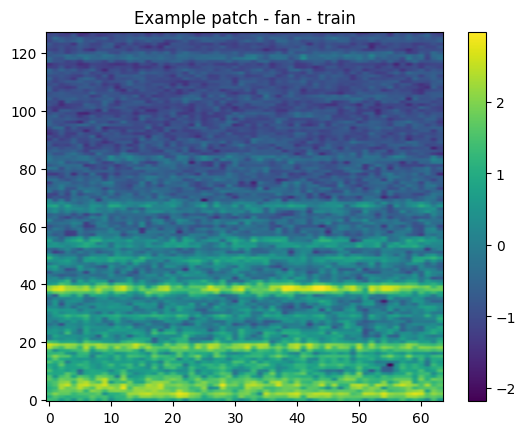

torch.Size([16, 1, 128, 64])

In [8]:
# show one patch
patch_batch, meta_batch = next(iter(train_loader))
patch = patch_batch[0].squeeze(0).numpy()
print(meta_batch[0]["path"])

plt.imshow(patch, origin="lower", aspect="auto")
plt.title(f"Example patch - {meta_batch[0]['machine_type']} - train")
plt.colorbar()
plt.show()

patch_batch.shape

### Convolutional autoencoder model

This code defines a convolutional autoencoder (CAE). The model consists of two parts:

1. **Encoder**  
   - Uses convolution, batch normalization, ReLU, and max-pooling layers.  
   - Compresses the input patch into a smaller, high-level representation.

2. **Decoder**  
   - Uses upsampling and convolution layers.  
   - Expands the compressed representation back to the original patch size.  
   - Outputs a reconstruction of the input spectrogram patch.

The autoencoder learns to reproduce normal sound patches.
Later, reconstruction errors can be used to detect anomalies.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: progressively reduces spatial dimensions and increases channel depth
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # -> [32, 128, 64]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> [32, 64, 32]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> [64, 64, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> [64, 32, 16]

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> [128, 32, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Decoder: upsamples back to the original patch size
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),  # -> [128, 64, 32]
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="nearest"),  # -> [64, 128, 64]
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),   # -> [1, 128, 64]
            # No activation: the output should match real-valued spectrogram patches
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = CNNAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS = 10


def train_one_epoch(model, loader, optimizer, device):
    """
    Train the model for one epoch on the provided DataLoader.
    """
    model.train()
    running_loss = 0.0

    for batch, (x, meta) in enumerate(loader):
        x = x.to(device)

        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


def eval_one_epoch(model, loader, device):
    """
    Evaluate the model on the validation set without gradient updates.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for x, meta in loader:
            x = x.to(device)
            x_hat = model(x)
            loss = criterion(x_hat, x)
            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = eval_one_epoch(model, val_loader, device)

    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

    # Track the best validation loss and save the model state
    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict().copy()

# Load the best-performing weights
model.load_state_dict(best_state)
torch.save(model.state_dict(), "cnn_autoencoder_fan.pt")

print("Best validation loss:", best_val)

Device: cuda
Epoch 01 | train loss: 0.1206 | val loss: 0.0940
Epoch 02 | train loss: 0.0899 | val loss: 0.0883
Epoch 03 | train loss: 0.0750 | val loss: 0.0842
Epoch 04 | train loss: 0.0697 | val loss: 0.0707
Epoch 05 | train loss: 0.0618 | val loss: 0.0636
Epoch 06 | train loss: 0.0574 | val loss: 0.0520
Epoch 07 | train loss: 0.0551 | val loss: 0.0506
Epoch 08 | train loss: 0.0529 | val loss: 0.0458
Epoch 09 | train loss: 0.0511 | val loss: 0.0451
Epoch 10 | train loss: 0.0484 | val loss: 0.0483
Best validation loss: 0.045091215739039334


### Visualizing original, reconstructed, and error patches

These functions show how well the autoencoder reconstructs spectrogram patches.

1. `plot_patch_reconstruction(orig, recon)`  
   - Displays the original patch, the reconstructed patch, and the absolute error map.  
   - This helps visually inspect what the model learned.

2. `show_reconstruction_examples(model, dataloader)`  
   - Runs the model on a few patches from the dataset.  
   - Uses the plotting function to show side-by-side comparisons.

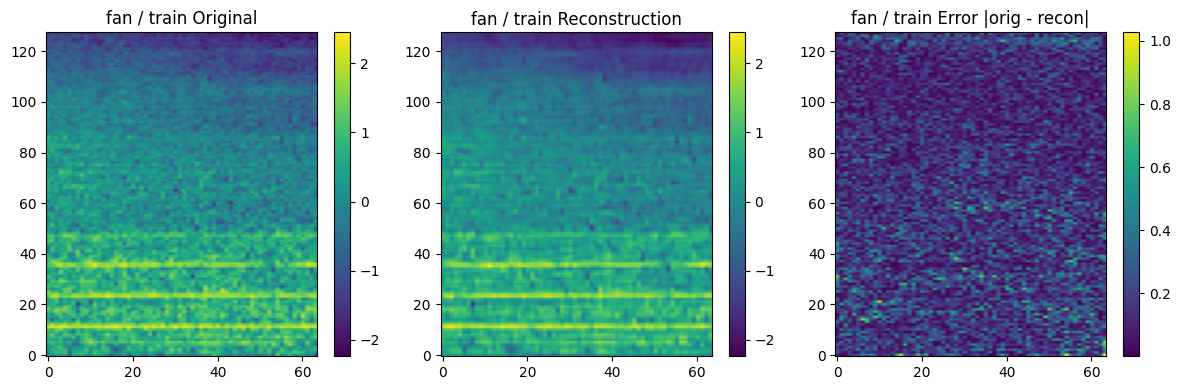

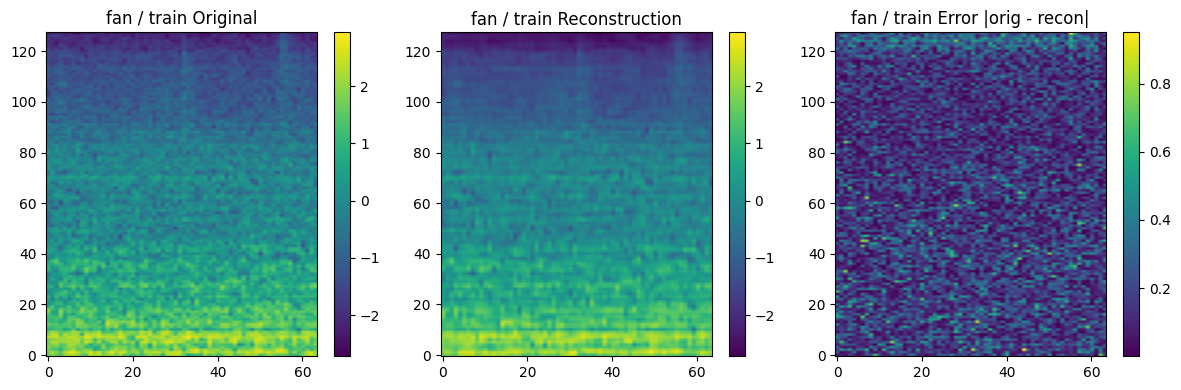

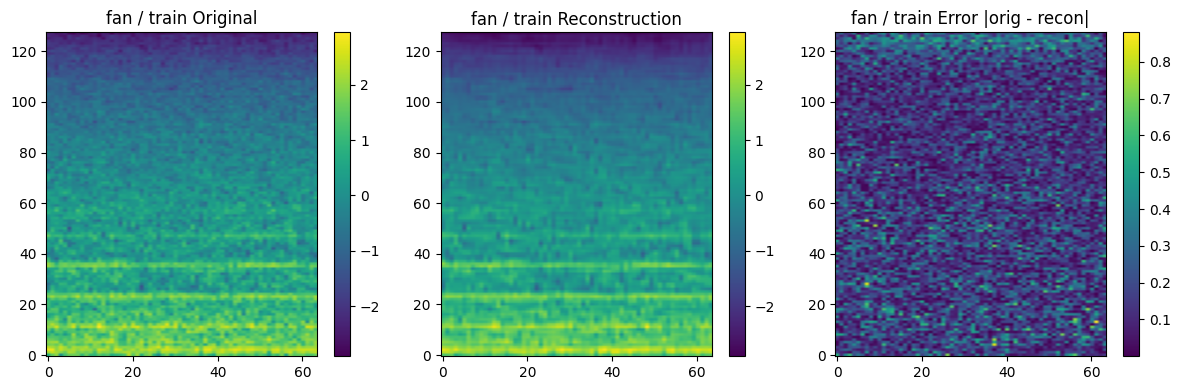

In [11]:
def plot_patch_reconstruction(orig, recon, title_prefix=""):
    """
    Plot the original patch, reconstructed patch, and the absolute error map.

    Parameters:
        orig  : numpy array of shape (n_mels, n_frames)
        recon : numpy array of shape (n_mels, n_frames)
    """
    error = np.abs(orig - recon)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    vmin = min(orig.min(), recon.min())
    vmax = max(orig.max(), recon.max())

    # Original patch
    im0 = axes[0].imshow(orig, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
    axes[0].set_title(f"{title_prefix} Original")
    plt.colorbar(im0, ax=axes[0])

    # Reconstructed patch
    im1 = axes[1].imshow(recon, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
    axes[1].set_title(f"{title_prefix} Reconstruction")
    plt.colorbar(im1, ax=axes[1])

    # Error map
    im2 = axes[2].imshow(error, origin="lower", aspect="auto")
    axes[2].set_title(f"{title_prefix} Error |orig - recon|")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()


def show_reconstruction_examples(model, dataloader, device, n_examples=3):
    """
    Display a number of reconstruction examples from the dataset.

    Parameters:
        model      : autoencoder model
        dataloader : DataLoader providing batches of patches
        device     : computation device
        n_examples : number of examples to display
    """
    model.eval()
    shown = 0

    with torch.no_grad():
        for x_batch, meta_batch in dataloader:
            x_batch = x_batch.to(device)
            x_hat_batch = model(x_batch)

            for i in range(x_batch.size(0)):
                orig = x_batch[i].cpu().squeeze(0).numpy()
                recon = x_hat_batch[i].cpu().squeeze(0).numpy()

                title_prefix = meta_batch[i]["machine_type"] + " / " + meta_batch[i]["split"]
                plot_patch_reconstruction(orig, recon, title_prefix=title_prefix)

                shown += 1
                if shown >= n_examples:
                    return


show_reconstruction_examples(model, val_loader, device, n_examples=3)

### Computing reconstruction losses for analysis

These functions measure how well the autoencoder reconstructs each patch.

1. `compute_reconstruction_losses(model, dataloader)`  
   - Runs the model on a dataset (train or validation).  
   - Computes the mean squared reconstruction error for each sample.  
   - Returns an array of per-sample losses.

2. After computing train and validation losses,  
   the mean and standard deviation are printed.  
   These numbers show how consistent the reconstruction quality is.

In [12]:
def compute_reconstruction_losses(model, dataloader, device):
    """
    Compute per-sample reconstruction losses for a given dataset.

    Returns:
        numpy array of mean squared error values, one per patch.
    """
    model.eval()
    losses = []

    with torch.no_grad():
        for x_batch, meta_batch in dataloader:
            x_batch = x_batch.to(device)
            x_hat = model(x_batch)

            # Compute squared error per pixel: shape [B, 1, 128, 64]
            per_pixel = (x_hat - x_batch) ** 2

            # Compute the mean reconstruction error per sample
            per_sample = per_pixel.view(per_pixel.size(0), -1).mean(dim=1)

            losses.extend(per_sample.cpu().numpy().tolist())

    return np.array(losses)

train_losses = compute_reconstruction_losses(model, train_loader, device)
val_losses   = compute_reconstruction_losses(model, val_loader, device)

print("Train loss: mean =", train_losses.mean(), "std =", train_losses.std())
print("Val loss:   mean =", val_losses.mean(), "std =", val_losses.std())

Train loss: mean = 0.04824739893024065 std = 0.004999703745397644
Val loss:   mean = 0.04827719956737797 std = 0.005167571620038741


### Test dataset and anomaly scoring

This code prepares a dataset and data loader for evaluating the autoencoder on test audio.

1. `DCASETestPatchDataset`  
   - Loads test files only.  
   - Uses the label from the filename (0 = normal, 1 = anomaly).  
   - Converts each file to a log-Mel spectrogram.  
   - Splits it into patches and returns one random patch per file.  
   - Applies the same normalization used during training.

2. A DataLoader is created that:  
   - Collects patch tensors into a batch,  
   - Collects the labels,  
   - Keeps metadata for reference.

3. The model processes the test patches, and the reconstruction error is computed:  
   - Squared error is averaged per patch.  
   - Errors and labels are stored for later analysis.

In [13]:
class DCASETestPatchDataset(Dataset):
    """
    Dataset for evaluating the autoencoder on test data.

    Each item returns:
        - one random spectrogram patch,
        - the label (0 = normal, 1 = anomaly),
        - metadata about the file.
    """

    def __init__(self, file_list, machine_type=None, normalize=True, mean_=0.0, std_=1.0):
        # Select test files with valid labels
        self.files = [
            f for f in file_list
            if f["split"] == "test" and f["label"] is not None
        ]

        # Optional: filter by machine type
        if machine_type is not None:
            self.files = [f for f in self.files if f["machine_type"] == machine_type]

        self.normalize = normalize
        self.mean_ = mean_
        self.std_ = std_

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        meta = self.files[idx].copy()
        y = load_audio(meta["path"])
        spec = audio_to_logmelspec(y)
        patches = spec_to_patches(spec)

        # Randomly select one patch from the file
        p_idx = np.random.randint(0, patches.shape[0])
        patch = patches[p_idx]

        # Apply normalization if required
        if self.normalize:
            patch = (patch - self.mean_) / self.std_

        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)
        label = meta["label"]

        return patch_tensor, label, meta


# Create the test dataset
test_dataset = DCASETestPatchDataset(
    file_list,
    machine_type="fan",
    normalize=True,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

# DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda batch: (
        torch.stack([b[0] for b in batch]),                 # patches
        torch.tensor([b[1] for b in batch], dtype=torch.long),  # labels
        [b[2] for b in batch],                              # metadata
    ),
)

# Compute reconstruction losses for the test set
test_losses = []
test_labels = []

model.eval()
with torch.no_grad():
    for x_batch, labels_batch, meta_batch in test_loader:
        x_batch = x_batch.to(device)
        x_hat_batch = model(x_batch)

        per_pixel = (x_hat_batch - x_batch) ** 2
        per_sample = per_pixel.view(per_pixel.size(0), -1).mean(dim=1)

        test_losses.extend(per_sample.cpu().numpy().tolist())
        test_labels.extend(labels_batch.numpy().tolist())

test_losses = np.array(test_losses)
test_labels = np.array(test_labels)

### Comparing reconstruction errors for normal and anomalous test patches

This code compares how well the autoencoder reconstructs normal and anomalous
test patches.

1. Split the reconstruction losses into two groups:
   - normal samples  
   - anomalous samples  

2. Plot their distributions as overlapping histograms.
   This shows whether anomalies produce higher reconstruction errors.

3. Print the mean and standard deviation for each group.

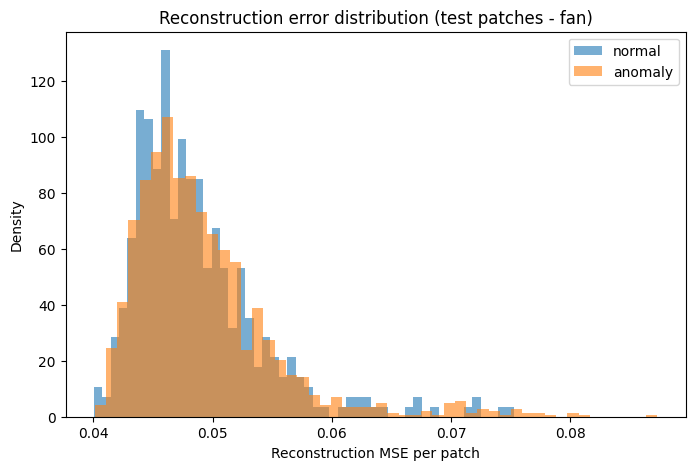

Normal  mean: 0.04867359010502696 std: 0.005521912491346933
Anomaly mean: 0.049185838396266356 std: 0.0061297822824595


In [14]:
normal_losses  = test_losses[test_labels == 0]
anomaly_losses = test_losses[test_labels == 1]

plt.figure(figsize=(8, 5))
plt.hist(normal_losses,  bins=50, alpha=0.6, label="normal",  density=True)
plt.hist(anomaly_losses, bins=50, alpha=0.6, label="anomaly", density=True)
plt.xlabel("Reconstruction MSE per patch")
plt.ylabel("Density")
plt.legend()
plt.title("Reconstruction error distribution (test patches - fan)")
plt.show()

print("Normal  mean:", normal_losses.mean(),  "std:", normal_losses.std())
print("Anomaly mean:", anomaly_losses.mean(), "std:", anomaly_losses.std())

## Conclusion for the Mel-spectrogram experiment

### What we did
- Converted fan audio recordings into log-Mel spectrograms.  
- Split each spectrogram into small patches with a fixed size.  
- Trained a convolutional autoencoder using only normal recordings.  
- Evaluated how well the model reconstructed new patches from both normal and anomalous recordings.

### What the results show
- The model reconstructs normal patches well and with stable performance.  
- Reconstruction errors for normal and anomalous test patches are very close to each other.  
- The distribution of reconstruction errors overlaps almost completely.

### What this means
The autoencoder learns the general structure of the fan sounds but does not produce higher reconstruction errors for anomalous recordings. Because the difference in error is very small, the model cannot reliably distinguish normal sounds from anomalous ones using Mel-spectrogram patches alone.

## Test on unseen data (animal sounds)

to test the model on real-life data i downloaded [a kaggle dataset containing sound from animal voices](https://www.kaggle.com/datasets/rushibalajiputthewad/sound-classification-of-animal-voice?resource=download).

The func below loads a selected .wav, converst it to a log-mel spectrogram, extracts patches and plots the original, recontructed and error map.

In [15]:
def visualize_reconstruction_from_wav(
    wav_path,
    model,
    device,
    feature_fn,        # audio_to_logmelspec of audio_to_logstft
    patch_frames=PATCH_FRAMES,
    patch_hop=PATCH_HOP,
    mean_=0.0,
    std_=1.0,
):
    """
    Load a WAV file, convert to log-Mel or log-STFT, extract patches,
    pick one patch, run it through the model, and plot:
        - original patch
        - reconstructed patch
        - error map (absolute difference)
    """

    # Load audio
    y = load_audio(wav_path)

    # Convert to spectrogram
    spec = feature_fn(y)

    # Extract patches
    patches = spec_to_patches(spec, patch_frames=patch_frames, patch_hop=patch_hop)
    if len(patches) == 0:
        raise ValueError("Audio too short to extract a patch")

    # Pick a random patch
    p_idx = np.random.randint(0, patches.shape[0])
    orig = patches[p_idx]

    # Normalize if needed
    orig_norm = (orig - mean_) / std_

    # Convert to tensor
    x = torch.from_numpy(orig_norm).float().unsqueeze(0).unsqueeze(0).to(device)

    # Model reconstruction
    model.eval()
    with torch.no_grad():
        recon = model(x)[0].cpu().squeeze(0).numpy()

    # Undo normalization for visualization
    orig_vis = orig
    recon_vis = recon * std_ + mean_

    # Error map
    error = np.abs(orig_vis - recon_vis)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(13, 4))

    vmin = min(orig_vis.min(), recon_vis.min())
    vmax = max(orig_vis.max(), recon_vis.max())

    im0 = axes[0].imshow(orig_vis, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
    axes[0].set_title("Original patch")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(recon_vis, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
    axes[1].set_title("Reconstructed patch")
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(error, origin="lower", aspect="auto")
    axes[2].set_title("Error map |orig - recon|")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()


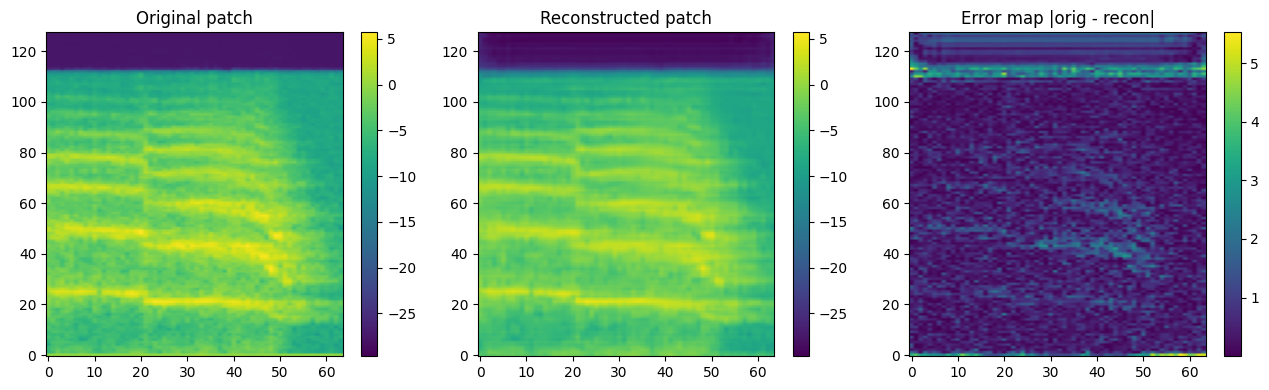

In [16]:
visualize_reconstruction_from_wav(
    "test_sounds/animal_sounds/Elephant/Elephant_1.wav",
    model,
    device,
    feature_fn=audio_to_logmelspec,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

In [17]:
def compute_patch_scores_for_file(
    wav_path,
    model,
    device,
    feature_fn,
    mean_,
    std_,
    patch_frames=PATCH_FRAMES,
    patch_hop=PATCH_HOP,
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
):
    """
    Compute reconstruction-based anomaly scores over time for a single audio file.

    Returns:
        times_sec : numpy array of shape (n_patches,)
        scores    : numpy array of shape (n_patches,)
    """
    # Load audio
    y = load_audio(wav_path, sr=sample_rate)

    # Spectrogram (Mel or STFT, depending on feature_fn)
    spec = feature_fn(y)

    # Manually extract patches and keep track of start indices
    n_mels, n_frames = spec.shape

    if n_frames < patch_frames:
        pad_width = patch_frames - n_frames
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
        n_frames = spec.shape[1]

    patches = []
    starts = []  # start frame index per patch

    for start in range(0, n_frames - patch_frames + 1, patch_hop):
        end = start + patch_frames
        patch = spec[:, start:end]
        patches.append(patch)
        starts.append(start)

    patches = np.stack(patches, axis=0)   # (n_patches, n_mels, patch_frames)
    starts = np.array(starts)

    # Normalize patches
    patches_norm = (patches - mean_) / std_

    # To tensor [N, 1, n_mels, patch_frames]
    x = torch.from_numpy(patches_norm).float().unsqueeze(1).to(device)

    # Run through model
    model.eval()
    with torch.no_grad():
        x_hat = model(x)

    # Reconstruction MSE per patch
    per_pixel = (x_hat - x) ** 2
    scores = per_pixel.view(per_pixel.size(0), -1).mean(dim=1).cpu().numpy()

    # Time axis: use center of each patch
    frame_hop_sec = hop_length / sample_rate
    center_frames = starts + patch_frames / 2.0
    times_sec = center_frames * frame_hop_sec

    return times_sec, scores


In [18]:
# Find one normal and one anomalous fan test file
fan_normal = next(
    f for f in file_list
    if f["machine_type"] == "fan" and f["split"] == "test" and f["label"] == 0
)

fan_anomaly = next(
    f for f in file_list
    if f["machine_type"] == "fan" and f["split"] == "test" and f["label"] == 1
)

fan_normal_path = fan_normal["path"]
fan_anomaly_path = fan_anomaly["path"]

elephant_path = Path("test_sounds/animal_sounds/Elephant/Elephant_1.wav")

print("Fan normal:", fan_normal_path)
print("Fan anomaly:", fan_anomaly_path)
print("Elephant:", elephant_path)


Fan normal: ..\data\fan\test\normal_id_00_00000000.wav
Fan anomaly: ..\data\fan\test\anomaly_id_00_00000000.wav
Elephant: test_sounds\animal_sounds\Elephant\Elephant_1.wav


In [ ]:
# Make sure model is your trained Mel autoencoder and train_dataset is defined
feature_fn = audio_to_logmelspec
mean_ = train_dataset.mean_
std_ = train_dataset.std_

t_fan_norm, s_fan_norm = compute_patch_scores_for_file(
    fan_normal_path,
    model,
    device,
    feature_fn,
    mean_,
    std_,
)

t_fan_anom, s_fan_anom = compute_patch_scores_for_file(
    fan_anomaly_path,
    model,
    device,
    feature_fn,
    mean_,
    std_,
)

t_elephant, s_elephant = compute_patch_scores_for_file(
    elephant_path,
    model,
    device,
    feature_fn,
    mean_,
    std_,
)

### Average reconstruction error per recording

The bar plot below compares the mean reconstruction error of:
- one normal fan recording,
- one anomalous fan recording,
- one elephant recording (out-of-domain).

Higher values indicate that the autoencoder has more difficulty reconstructing the sound.

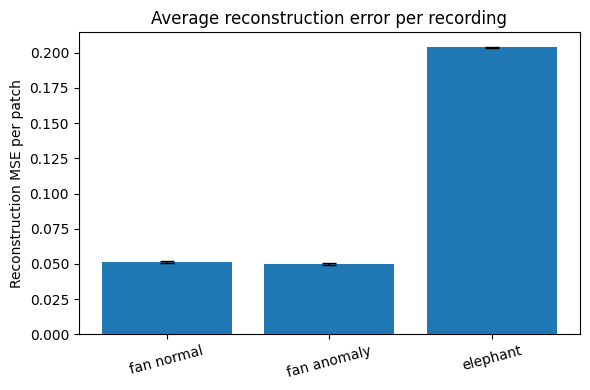

Mean reconstruction error per recording:
fan normal   mean = 0.0513, std = 0.0010
fan anomaly  mean = 0.0501, std = 0.0006
elephant     mean = 0.2037, std = 0.0006


In [21]:
# Collect means and standard deviations
labels = ["fan normal", "fan anomaly", "elephant"]
means = [
    float(s_fan_norm.mean()),
    float(s_fan_anom.mean()),
    float(s_elephant.mean()),
]
stds = [
    float(s_fan_norm.std()),
    float(s_fan_anom.std()),
    float(s_elephant.std()),
]

# Bar plot with error bars
plt.figure(figsize=(6, 4))
x = np.arange(len(labels))

plt.bar(x, means, yerr=stds, capsize=5)

plt.xticks(x, labels, rotation=15)
plt.ylabel("Reconstruction MSE per patch")
plt.title("Average reconstruction error per recording")
plt.tight_layout()
plt.show()

print("Mean reconstruction error per recording:")
for label, m, s in zip(labels, means, stds):
    print(f"{label:12s} mean = {m:.4f}, std = {s:.4f}")


In [22]:
from pathlib import Path

# Use the Mel feature function and training normalization
feature_fn = audio_to_logmelspec
mean_ = train_dataset.mean_
std_ = train_dataset.std_

# 1. Collect mean reconstruction error per fan NORMAL test file
fan_test_normals = [
    f for f in file_list
    if f["machine_type"] == "fan" and f["split"] == "test" and f["label"] == 0
]

fan_normal_means = []
for f in fan_test_normals:
    _, scores = compute_patch_scores_for_file(
        f["path"],
        model,
        device,
        feature_fn,
        mean_,
        std_,
    )
    fan_normal_means.append(scores.mean())

fan_normal_means = np.array(fan_normal_means)

# Choose threshold as 95th percentile of normal fan test errors
threshold = np.percentile(fan_normal_means, 95)
print(f"Threshold (95th percentile of fan normal test errors): {threshold:.6f}")

# 2. Apply to all fan test files (normal + anomaly)
fan_test_all = [
    f for f in file_list
    if f["machine_type"] == "fan" and f["split"] == "test" and f["label"] is not None
]

fan_scores = []
fan_true_labels = []  # 0 = normal, 1 = anomaly

for f in fan_test_all:
    _, scores = compute_patch_scores_for_file(
        f["path"],
        model,
        device,
        feature_fn,
        mean_,
        std_,
    )
    fan_scores.append(scores.mean())
    fan_true_labels.append(int(f["label"]))

fan_scores = np.array(fan_scores)
fan_true_labels = np.array(fan_true_labels)

fan_pred_abnormal = (fan_scores > threshold).astype(int)  # 1 = predicted abnormal

# Summary for DCASE fan test
n_fan = len(fan_scores)
n_normal = int((fan_true_labels == 0).sum())
n_anomaly = int((fan_true_labels == 1).sum())

n_normal_flagged = int(((fan_true_labels == 0) & (fan_pred_abnormal == 1)).sum())
n_anomaly_flagged = int(((fan_true_labels == 1) & (fan_pred_abnormal == 1)).sum())

print("\nDCASE fan test summary (per recording):")
print(f"Total fan test files:        {n_fan}")
print(f"  Normal files:              {n_normal}")
print(f"  Anomaly files:             {n_anomaly}")
print(f"  Normal flagged abnormal:   {n_normal_flagged} "
      f"({n_normal_flagged / n_normal:.2%} of normals)")
print(f"  Anomaly flagged abnormal:  {n_anomaly_flagged} "
      f"({n_anomaly_flagged / n_anomaly:.2%} of anomalies)")

# 3. Apply to all animal sounds
animal_root = Path("test_sounds/animal_sounds")
animal_files = sorted(animal_root.rglob("*.wav"))

animal_scores = []
animal_paths = []

for p in animal_files:
    try:
        _, scores = compute_patch_scores_for_file(
            p,
            model,
            device,
            feature_fn,
            mean_,
            std_,
        )
        animal_scores.append(scores.mean())
        animal_paths.append(p)
    except Exception as e:
        print(f"Skipping {p} due to error: {e}")

animal_scores = np.array(animal_scores)
animal_pred_abnormal = animal_scores > threshold

n_animal = len(animal_scores)
n_animal_abnormal = int(animal_pred_abnormal.sum())

print("\nAnimal sounds summary (per recording):")
print(f"Total animal files:          {n_animal}")
print(f"  Flagged as abnormal:       {n_animal_abnormal} "
      f"({n_animal_abnormal / n_animal:.2%} of animal sounds)")

Threshold (95th percentile of fan normal test errors): 0.058718

DCASE fan test summary (per recording):
Total fan test files:        1875
  Normal files:              400
  Anomaly files:             1475
  Normal flagged abnormal:   20 (5.00% of normals)
  Anomaly flagged abnormal:  83 (5.63% of anomalies)

Animal sounds summary (per recording):
Total animal files:          650
  Flagged as abnormal:       650 (100.00% of animal sounds)


### Interpretation of the anomaly detection results

The threshold was set to the 95th percentile of the reconstruction errors from
normal fan test recordings. This means only the highest 5% of normal fan
recordings should exceed this threshold.

**DCASE fan test performance**

- Normal recordings classified as abnormal: 5.0%  
- Anomalous recordings classified as abnormal: 5.63%

The model flags normal and anomalous fan recordings at almost the same rate.
This shows that the autoencoder does not distinguish subtle machine anomalies
from normal behaviour. The reconstruction error distribution of normal and
anomalous fans is too similar to make reliable decisions.

**Animal sound performance**

All 650 animal recordings were flagged as abnormal (100%).  
These sounds are very different from fan recordings, and the autoencoder cannot
reconstruct them well.

**Conclusion**

The autoencoder successfully detects sounds that are completely different from
the training data (animals), but it does not detect subtle anomalies within the
same machine type (fan). This confirms that a reconstruction-based autoencoder
behaves more as an out-of-distribution detector than as a true anomaly detector
for mechanical faults.